In [427]:
# all needed libraries are imported here
import re
import sys
import requests as requests
import pandas as pd
import matplotlib.pyplot as plt
import wikipedia as wiki
import numpy as np
from statsmodels.stats import diagnostic
import wikipediaapi
import os
import pandas as pd
import sys
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import statsmodels.formula.api as smf

# 1. Data scraping

We use the REST API from http://petermeissner.de:8880/ in order to extract pageviews for the articles,
from January 2012 up until december 2015.
We do this for both English and German Wikipedia.

In [428]:
# Helper function, extracts pageviews for a list of articles and a given language and specified years
# and returns a dataframe with the associated information

def get_pageview_data(articles, years, lang, save_csv=True):
    
    # initialize the search url
    search_url = f'http://petermeissner.de:8880/article/exact/{lang}/'
    final_list = []
    
    for article in articles:
        
        # small technical detail, we have to transofrm spaces in the page names into underscores.
        article_no_spaces = re.sub(r'\s','_', article)
        try:
            request = requests.get(search_url + article_no_spaces).json()
        except:
            print(f'Problem fetching data for article {article}')
            continue
            
            
        # verify everything went well
        if request['status'] != 'ok':
            print(f'Problem fetching data for article {article}')
            continue
            
        data = request['data']
        for elem in data:
            year = elem['year']
            if str(year) in years:
                # create a date_range for the specific year
                timestamps = pd.date_range(f'01-01-{year}', f'31-12-{year}')
                page_views = elem['page_view_count'].split(',')
                # quick sanity check
                assert len(timestamps) == len(page_views)
                final_list += list(zip(timestamps, [article] * len(timestamps), [lang] * len(timestamps), page_views))
    
    # create the needed dataframe and save it if specified
    df = pd.DataFrame(final_list, columns=['date', 'article','language', 'pageviews'])
    if save_csv:
        df.to_csv(f'data/data_{lang}.csv')
    return df
    

In [501]:
# Declare the desired article names for English and German

terrorism_articles_en = ['abu_sayyaf', 'afghanistan', 'agro', 'al-qaeda',
                      'al-qaeda_in_the_arabian_peninsula',
                      'al-qaeda_in_the_islamic_maghreb', 'al-shabaab',
                      'ammonium_nitrate', 'attack', 'biological_weapon', 'car_bomb',
                      'chemical_weapon', 'conventional_weapon', 'dirty_bomb',
                      'eco-terrorism', 'environmental_terrorism',
                      'euskadi_ta_askatasuna', 'extremism', 'farc', 'fundamentalism',
                      'hamas', 'hezbollah', 'improvised_explosive_device', 'iran',
                      'iraq', 'irish_republican_army', 'islamist', 'jihad',
                      'nationalism', 'nigeria', 'nuclear', 'nuclear_enrichment',
                      'pakistan', 'palestine_liberation_front', 'pirates', 'plo',
                      'political_radicalism', 'recruitment', 'somalia', 'suicide_attack',
                      'suicide_bomber', 'taliban', 'tamil_tigers',
                      'tehrik-i-taliban_pakistan', 'terror', 'terrorism',
                      'weapons-grade', 'yemen']

terrorism_articles_de = ['al-Qaida','Terrorismus', 'Terror (Begriffsklärung)', 'Angriff', 'Irak', 'Afghanistan',
                        'Iran', 'Pakistan', 'Agroterrorismus', 'Ökoterrorismus','Hochangereichertes Uran',"Chemische Waffe", "Ammoniumnitrat",
                        "Unkonventionelle Spreng- und Brandvorrichtung", "Abu Sajaf", "Hamas",
                        "FARC-EP", "Geschichte der Irisch-Republikanischen Armee", "Euskadi Ta Askatasuna" , "Hisbollah",
                        "Liberation Tigers of Tamil Eelam", "Palästinensische Befreiungsorganisation", "Palästinensische Befreiungsfront", 
                        "Autobombe", "Dschihad", "Taliban",
                        'Islamismus', 'Fundamentalismus', 'Personalbeschaffung', 'Nationalismus', 'Al-Shabaab',
                        'Radikalismus', 'Nigeria', 'Somalia', 'Extremismus', 'Piraterie', 'Jemen', 'Tehrik-i-Taliban Pakistan',
                        'Al-Qaida im Maghreb', 'Al-Qaida auf der Arabischen Halbinsel', 'Selbstmordattentat']

years = ['2012','2013','2014','2015']

In [539]:
# small convenience variable so that we don't have to re_use the api each time
use_api = False

if use_api:
    data_en = get_pageview_data(terrorism_articles_en, years, 'en', save_csv=True)
    data_de = get_pageview_data(terrorism_articles_de, years, 'de', save_csv=True)
else:
    data_en = pd.read_csv('data/data_en.csv', parse_dates=['date'], index_col=0)
    data_de = pd.read_csv('data/data_de.csv', parse_dates=['date'], index_col=0)

data_en['pageviews'] = data_en['pageviews'].astype(int)

Problem fetching data for article Geschichte der Irisch-Republikanischen Armee


There is a problem fetching data for the german version of the irish republican army article, although it does exist on Wikipedia.

In [540]:
data_en.head()

,date,article,language,pageviews
0,2012-01-01,abu_sayyaf,en,254
1,2012-01-02,abu_sayyaf,en,351
2,2012-01-03,abu_sayyaf,en,423
3,2012-01-04,abu_sayyaf,en,418
4,2012-01-05,abu_sayyaf,en,804


In [541]:
data_de.head()

,date,article,language,pageviews
0,2012-01-01,al-Qaida,de,438
1,2012-01-02,al-Qaida,de,9
2,2012-01-03,al-Qaida,de,669
3,2012-01-04,al-Qaida,de,659
4,2012-01-05,al-Qaida,de,746


# 2. Verifications and Tests
We perform some sanity checks on the data, and find that some values may be missing. For the English articles, we compare the results with the data given to us for Milestone P2 replication.

## Checks

In [542]:
print(len(data_en.article.unique()))
print(len(terrorism_articles_en))
print(len(data_de.article.unique()))
print(len(terrorism_articles_de))

48
48
40
41


This is expected as we were not able to retrieve one of the German articles data

In [543]:
# load the pageviews given for the replication
reference = pd.read_csv('data/terrorism_data.csv')
testing_ref_data = reference.set_index(['date','article']).loc[:, 'views'].astype(int).sort_index(level=[0,1])

test_en = data_en.loc[data_en.date.isin(reference.date)].set_index(['date','article']).\
       sort_index(level=[0,1])['pageviews'].astype(int)

np.count_nonzero((test_en.values == testing_ref_data.values)) == len(test_en)

True

We have **exactly the same** pageviews as the ones given for the replication, which a good sign.

## Scatter plots of the data

In [544]:
data_de

,date,article,language,pageviews
0,2012-01-01,al-Qaida,de,438
1,2012-01-02,al-Qaida,de,9
2,2012-01-03,al-Qaida,de,669
3,2012-01-04,al-Qaida,de,659
4,2012-01-05,al-Qaida,de,746
...,...,...,...,...
58435,2014-12-27,Selbstmordattentat,de,35
58436,2014-12-28,Selbstmordattentat,de,41
58437,2014-12-29,Selbstmordattentat,de,43
58438,2014-12-30,Selbstmordattentat,de,44


In [552]:
# Aggregate the total monthly pageviews
data_en.loc[:,'pageviews'] = data_en.loc[:,'pageviews'].astype(int)
data_de.loc[:,'pageviews'] = data_de.loc[:,'pageviews'].astype(int)

grouped_en = data_en.groupby(pd.Grouper(key='date', freq='M'))['pageviews'].sum()
grouped_de = data_de.groupby(pd.Grouper(key='date', freq='M'))['pageviews'].sum()

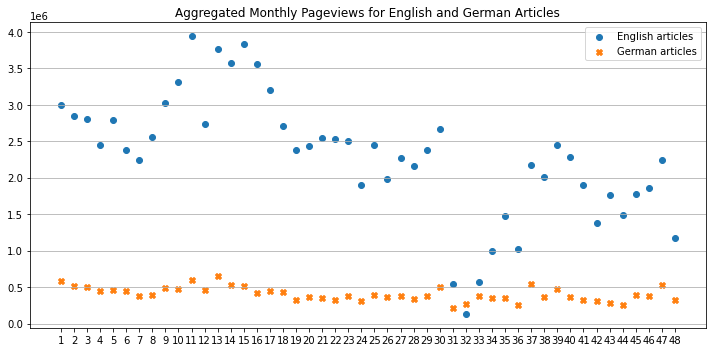

In [553]:
plt.figure(figsize=(10,5))
plt.scatter(x=range(1,len(grouped_en) + 1), y=grouped_en.values, label='English articles')
plt.scatter(x=range(1,len(grouped_de) + 1), y=grouped_de.values, marker='X', label='German articles')

plt.title('Aggregated Monthly Pageviews for English and German Articles')

plt.grid (False, axis='x')
plt.grid (True, axis='y')
plt.xticks(range(1,len(grouped_en) + 1))
plt.legend()
plt.savefig('figures/agg.png')
plt.tight_layout()

plt.show()

For the English articles, we notice **very low pageview** values from July 2014 until Dec 2014.

## Testing for missing pageview Data
Seeing the outlier points in the scatter plots we look for missing values in the data

In [554]:
(data_en['pageviews'] == 0).sum()

6627

In [555]:
(data_de['pageviews'] == 0).sum()

5449

As we can see, there seems to be many zeros in the data. What about for the monthly case?

In [556]:
data_en

,date,article,language,pageviews
0,2012-01-01,abu_sayyaf,en,254
1,2012-01-02,abu_sayyaf,en,351
2,2012-01-03,abu_sayyaf,en,423
3,2012-01-04,abu_sayyaf,en,418
4,2012-01-05,abu_sayyaf,en,804
...,...,...,...,...
70123,2014-12-27,yemen,en,1895
70124,2014-12-28,yemen,en,1929
70125,2014-12-29,yemen,en,2180
70126,2014-12-30,yemen,en,0


In [557]:
(data_en.groupby(['article',pd.Grouper(key='date', freq='M')])['pageviews'].sum() == 0).sum()

35

In [558]:
(data_de.groupby(['article',pd.Grouper(key='date', freq='M')])['pageviews'].sum() == 0).sum()

39

We conclude that there are many **missing values** in the data, as it is not plausible to have whole months without any pageviews. We should keep this in mind when interpreting the data.

# Q1: Is the Chilling effect found persistent?

In [559]:
# Helper function, performs all the necessary operations to prepare the data for ITS regression

def prepare_data_for_regression(data):
    pageviews_per_month = data.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()
    # june 2013 and its index, where the months are counted from 1 to 32
    june_2013 = pd.to_datetime('2013-06-30')
    june_2013_index = 18 

    # prepare columns for the regression
    
    # intervention is an indicator function, which takes the value 1 for rows after June 2013
    pageviews_per_month['intervention'] = (pageviews_per_month.date >= june_2013).astype(int)

    # time is the sequence [1,2,..,32] as we have 32 months
    pageviews_per_month ['time'] = range(1,len(pageviews_per_month) + 1)

    # post_slope is 0 before June 2013, then 1,2,.. starting June 2013
    pageviews_per_month['post_slope'] = (pageviews_per_month['time'] - june_2013_index + 1) * \
                                         pageviews_per_month['intervention']
    
    return pageviews_per_month

# Q2: Is the Chilling effect only restrained to English Wikipedia?

## 2.1 Initial regression
Here we perform the same ITS regression on the German Articles we retrieved in the Data Scraping section.

In [560]:
# filter all rows corresponding to the article about Hamas, for consistency with the paper
data_de = data_de.query('(article != "Hamas")')

# Keep the same date range as the paper
data_de = data_de.loc[data_de.date <= '31-08-2014']

In [561]:
reg_data_de = prepare_data_for_regression(data_de)
model_de = smf.ols(formula='pageviews ~ time + C(intervention) + post_slope', data=reg_data_de).fit()
model_de.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pageviews   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     9.266
Date:                Sat, 19 Dec 2020   Prob (F-statistic):           0.000203
Time:                        01:10:30   Log-Likelihood:                -401.46
No. Observations:                  32   AIC:                             810.9
Df Residuals:                      28   BIC:                             816.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             4.779e+05   3.69e+04     12.966      0.000    4.02e+05    5.53e+05
C(intervention)[T.1] -8.544e+04   5.19e+04     -1.645      0.111   -1.92e+05    2.09e+04
time                  -538.6985   3596.771     -0.150      0.882   -7906.350    6828.952
post_slope           -4740.4158   5638.038     -0.841      0.408   -1.63e+04    6808.581
==============================================================================
Omnibus:                        4.140   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                2.678
Skew:                           0.495   Prob(JB):                        0.262
Kurtosis:                       4.014   Cond. No.                         83.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The regression results show:
* The model fit isn't great, we have an $Adj.R^2 = 0.444$ which is on the low side.
* the pageviews seem not to depend much on time, meaning that the pageviews before and after the intervention fluctuate along a constant value.
* There is **no statistically** significant effect of the intervention on the pageviews for German Wikipedia. 

In [563]:
preds_de = model_de.get_prediction(reg_data_de)\
                .summary_frame(alpha=0.05)[['mean','mean_ci_lower', 'mean_ci_upper']]

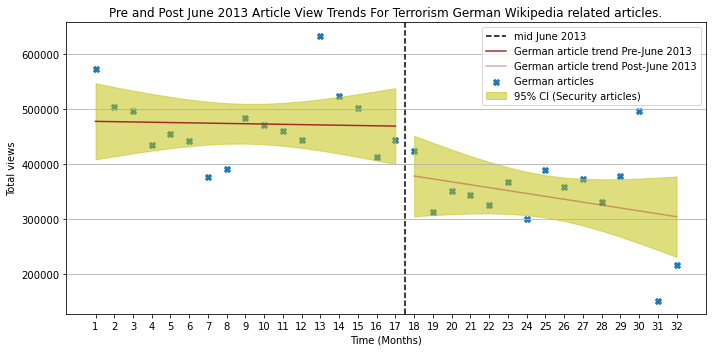

In [564]:
# plotting the results
plt.figure(figsize=(10,5)) 

# some useful indexes (in the dataframe), ticks, etc
xticks = range(1, preds_de.shape[0] + 1)
start_index = 1
before_interruption_index = 17
after_interruption_index = 18
end_index = 32
# equivalent indexes in the dataframe
points_index = [start_index - 1, before_interruption_index - 1, after_interruption_index - 1, end_index - 1] 
# useful mask, when plotting CIs
ci_mask_before = np.array(xticks) <= before_interruption_index


# plot the article views
plt.scatter(data=reg_data_de ,x='time', y='pageviews', marker='X', label='German articles')

# Add ticks and a line representing the period just before the intervention
plt.xticks(xticks)
plt.axvline(x=after_interruption_index - 0.5, c='black', label='mid June 2013',ls='--')

p1, p2, p3, p4 = preds_de.loc[points_index, 'mean']
plt.plot ([start_index, before_interruption_index], [p1, p2] , c='brown', label= 'German article trend Pre-June 2013')
plt.plot ([after_interruption_index, end_index], [p3, p4] ,c='brown', alpha=0.4, label= 'German article trend Post-June 2013')
plt.fill_between(x=xticks, y1=preds_de['mean_ci_lower'], y2=preds_de['mean_ci_upper'],color='y', where=ci_mask_before, alpha=0.5, \
                 label='95% CI (Security articles)')
plt.fill_between(x=xticks, y1=preds_de['mean_ci_lower'], y2=preds_de['mean_ci_upper'],color='y', where=~ci_mask_before, alpha=0.5)


# Add Title, labels and legend 
plt.title ("Pre and Post June 2013 Article View Trends For Terrorism German Wikipedia related articles.")
plt.xlabel("Time (Months)")
plt.ylabel("Total views")
plt.legend()

# Keep only the horizontal grid
plt.grid (False, axis='x')
plt.grid (True, axis='y')
plt.tight_layout()


plt.savefig('figures/reg_german.png')
plt.show()



## 2.1 Data considered removed suicide bomber
difference here:  
why here:

In [567]:
terrorism_articles_en = ['Abu Sayyaf', 'afghanistan', 'Agro-terrorism', 'al-qaeda',
       'Al-Qaeda in the Arabian Peninsula',
       'Al-Qaeda in the Islamic Maghreb', 'al-shabaab',
       'ammonium_nitrate', 'Offensive (military)', 'biological_weapon', 'car_bomb',
       'chemical_weapon', 'conventional_weapon', 'dirty_bomb',
       'eco-terrorism', 'environmental_terrorism',
       'Euskadi ta Askatasuna', 'extremism', 'farc', 'fundamentalism',
       'hamas', 'hezbollah', 'improvised_explosive_device', 'iran',
       'iraq', 'Irish Republican Army', 'islamist', 'jihad',
       'nationalism', 'nigeria', 'Nuclear weapon', 'nuclear_enrichment',
       'pakistan', 'Palestine Liberation Front', 'pirates', 'PLO',
       'political_radicalism', 'recruitment', 'somalia', 'suicide_attack',
        'taliban', 'tamil_tigers',
       'Tehrik-i-Taliban Pakistan', 'Terror (politics)', 'terrorism',
       'weapons-grade', 'yemen']

categories_selected_de = ['Kategorie:Afghanistan', 'Kategorie:Afghanistankrieg (seit 1978)', 'Kategorie:Al-Qaida',
                          'Kategorie:Antisemitismus', 'Kategorie:Anti-Freimaurerei','Kategorie:Antizionismus',
                          'Kategorie:Asymmetrische Kriegführung', 'Kategorie:Attentat', 'Kategorie:Bewaffnete islamistische Organisation',
                          'Kategorie:Bewaffnete islamistische Organisation', 'Kategorie:Bewaffnete islamistische Untergrundorganisation',
                          'Kategorie:Bombe', 'Kategorie:Hamas', 'Kategorie:Hisbollah','Kategorie:Islamische Republik',
                          'Kategorie:Islamistischer Terrorismus','Kategorie:Terrorismus', 'Kategorie:Taliban']

### 2.1.1 English

In [569]:
# Get pageview data for the newly defined articles
pageviews_en = get_pageview_data(terrorism_articles_en, ['2012', '2013','2014'], 'en', save_csv=False) 

In [311]:
# # We only keep the articles that have a  meaningful amount of pageviews, or that are direct translations of an English article
# pageviews_en.loc[:,'pageviews'] = pageviews_en['pageviews'].astype(int)
# total_pageviews_en = pageviews_en.groupby('article')['pageviews'].sum() 
# articles_kept_en = total_pageviews_en[total_pageviews_en > 10000].index.unique()
# pageviews_en = pageviews_en[pageviews_en.article.isin(articles_kept_en)]

In [570]:
len(pageviews_en.article.unique())

47

In [571]:
pageviews_en.head()

,date,article,language,pageviews
0,2012-01-01,Abu Sayyaf,en,254
1,2012-01-02,Abu Sayyaf,en,351
2,2012-01-03,Abu Sayyaf,en,423
3,2012-01-04,Abu Sayyaf,en,418
4,2012-01-05,Abu Sayyaf,en,804


In [572]:
# Helper function, retrieves page summaries, optinnally look for other languages equivalents
def get_page_summaries(pages, lang, look_for_other_lang=False, other_lang='de'):

    summaries = []
    wiki = wikipediaapi.Wikipedia(lang)
    
    for page in pages:
        try:
            # find the desired page
            page_en = wiki.page(page)
            if look_for_other_lang:
                # try to find the different language equivalent, return None otherwise
                page_other = page_en.langlinks.get(other_lang, None)
                page_other_title = page_other.title if page_other else None
                summaries.append({f'article_{lang}': page, f'summary_{lang}': page_en.summary, 
                      f'article_{other_lang}': page_other_title})
            else:
                summaries.append({f'article_{lang}': page, f'summary_{lang}': page_en.summary})

        except:
            print(f"problem fetching data for page: {page}", file=sys.stderr)
            continue
        
    return pd.DataFrame(summaries)

In [574]:
summaries_en = get_page_summaries(pageviews_en.article.unique(), 'en', look_for_other_lang=True, other_lang='de')

In [576]:
summaries_en.head()

,article_en,summary_en,article_de
0,Abu Sayyaf,Abu Sayyaf ( (listen); Arabic: جماعة أبو سياف‎...,Abu Sajaf
1,afghanistan,"Afghanistan ( (listen), also pronounced /ævˈɡæ...",Afghanistan
2,Agro-terrorism,"Agroterrorism, also known as agriterrorism and...",Agroterrorismus
3,al-qaeda,"Al-Qaeda (; Arabic: القاعدة‎ al-Qāʿidah, IPA: ...",Al-Qaida
4,Al-Qaeda in the Arabian Peninsula,Al-Qaeda in the Arabian Peninsula (Arabic: تنظ...,Al-Qaida auf der Arabischen Halbinsel


### 2.1.2 German

In [577]:
# Helper function, to consider a wide range of pages, Retrieves all articles of a given category
def get_members_of_category(cat, lang, level=0, max_level=1):
    wiki = wikipediaapi.Wikipedia(lang)
    category_page = wiki.page(cat)
    all_pages_in_cat = []
    for c in category_page.categorymembers.values(): 
        if c.ns == wikipediaapi.Namespace.CATEGORY and level < max_level:
            all_pages_in_cat.extend(get_members_of_category(c, lang, level+1, max_level))
        elif c.ns == wikipediaapi.Namespace.MAIN: # check that page represents an article
            all_pages_in_cat.append(c.title)
    
    return all_pages_in_cat

In [578]:
# Fetch all members of the selected categories
articles_de = set(summaries_en['article_de'].dropna())
for category in categories_selected_de:
    articles_de.update(get_members_of_category(category,'de', 0, 5))

In [579]:
articles_de = list(articles_de)
print(articles_de[:10])

['Able Danger', 'Joshua Ryne Goldberg', 'Jamaat-ul-Mujahideen Bangladesh', 'Hamas-Charta', 'Revolutionäre Zellen (Deutschland)', 'Chalid Maschal', 'AN-M50', 'Russisches Forschungs- und Bildungszentrum „Holocaust“', 'Stabbrandbombe', 'Ritualmordvorwurf von Skurcz']


In [580]:
pageviews_de = get_pageview_data(articles_de, ['2012', '2013','2014'], 'de', save_csv=False)

Problem fetching data for article Ritualmordvorwurf von Skurcz
Problem fetching data for article Antisemitismus in der Türkei
Problem fetching data for article Beschädigung des Tagebuchs der Anne Frank
Problem fetching data for article B53/W53 (Kernwaffe)
Problem fetching data for article Itzig (Ethnophaulismus)
Problem fetching data for article Vertreibung von Juden aus arabischen und islamischen Ländern
Problem fetching data for article Liste von Anschlägen der Allied Democratic Forces
Problem fetching data for article Jamaat-ul-Ahrar
Problem fetching data for article Jugendwiderstand (Berliner Gruppe)
Problem fetching data for article GBU-53/B
Problem fetching data for article ASh-2
Problem fetching data for article Goyim Partei Deutschland
Problem fetching data for article Antisemitismus beim Aalster Karnevalsumzug
Problem fetching data for article Geschichte des Antisemitismus seit 1945
Problem fetching data for article Julie Manheimer
Problem fetching data for article Attentat au

In [581]:
pageviews_de.head()

,date,article,language,pageviews
0,2012-01-01,Able Danger,de,9
1,2012-01-02,Able Danger,de,0
2,2012-01-03,Able Danger,de,13
3,2012-01-04,Able Danger,de,11
4,2012-01-05,Able Danger,de,6


In [582]:
# We only keep the articles that have a  meaningful amount of pageviews, or that are direct translations of an English 
pageviews_de['pageviews'] = pageviews_de['pageviews'].astype(int)
total_pageviews = pageviews_de.groupby('article')['pageviews'].sum() 
articles_kept = total_pageviews[total_pageviews > 10000].index.unique()
pageviews_de = pageviews_de[pageviews_de.article.isin(articles_kept) | 
                            pageviews_de.article.isin(summaries_en.article_de.dropna().unique())]

In [583]:
# Quick verification that we have all articles we want to keep 
summaries_en[~summaries_en['article_de'].isin(pageviews_de.article.unique())]

,article_en,summary_en,article_de
8,Offensive (military),An offensive is a military operation that seek...,None
9,biological_weapon,"A biological agent (also called bio-agent, bio...",None
12,conventional_weapon,The terms conventional weapons or conventional...,None
13,dirty_bomb,A dirty bomb or radiological dispersal device ...,None
15,environmental_terrorism,Environmental terrorism consists of one or mor...,None
25,Irish Republican Army,The Irish Republican Army (IRA) is a name used...,Geschichte der Irisch-Republikanischen Armee
36,political_radicalism,Radical politics denotes the intent to transfo...,None
45,weapons-grade,Weapons-grade nuclear material is any fission...,None


In [584]:
# get summaries, drop duplicates in case two page names link to the same page
summaries_de = get_page_summaries(pageviews_de.article.unique(), 'de', look_for_other_lang=False).drop_duplicates(['summary_de'])

In [585]:
summaries_de = summaries_de.loc[~summaries_de.article_de.isin(summaries_en.article_de.unique())]

In [586]:
summaries_de.head()

,article_de,summary_de
0,Revolutionäre Zellen (Deutschland),Die Revolutionären Zellen (RZ) waren eine link...
1,Chalid Maschal,Chalid Maschal (* Mai 1956 in Silwad bei Ramal...
2,Stabbrandbombe,"Die Stabbrandbombe, auch Brandstab oder Elektr..."
3,Jemaah Islamiyah,Jemaah Islamiyah (JI; arabisch الجماعة الإسلام...
4,Flugzeugentführung,"Eine Flugzeugentführung (auch Luftpiraterie, e..."


## 2.2. Matching

In [593]:
treated_subjects = summaries_en.copy().loc[~summaries_en.article_de.isin(pageviews_de.article)]
untreated_subjects = summaries_de.copy()

In [594]:
treated_subjects

,article_en,summary_en,article_de
8,Offensive (military),An offensive is a military operation that seek...,None
9,biological_weapon,"A biological agent (also called bio-agent, bio...",None
12,conventional_weapon,The terms conventional weapons or conventional...,None
13,dirty_bomb,A dirty bomb or radiological dispersal device ...,None
15,environmental_terrorism,Environmental terrorism consists of one or mor...,None
25,Irish Republican Army,The Irish Republican Army (IRA) is a name used...,Geschichte der Irisch-Republikanischen Armee
36,political_radicalism,Radical politics denotes the intent to transfo...,None
45,weapons-grade,Weapons-grade nuclear material is any fission...,None


In [595]:
untreated_subjects.head()

,article_de,summary_de
0,Revolutionäre Zellen (Deutschland),Die Revolutionären Zellen (RZ) waren eine link...
1,Chalid Maschal,Chalid Maschal (* Mai 1956 in Silwad bei Ramal...
2,Stabbrandbombe,"Die Stabbrandbombe, auch Brandstab oder Elektr..."
3,Jemaah Islamiyah,Jemaah Islamiyah (JI; arabisch الجماعة الإسلام...
4,Flugzeugentführung,"Eine Flugzeugentführung (auch Luftpiraterie, e..."


In [596]:
# We need unique indices between the two frames for the matching
untreated_subjects = untreated_subjects.set_index(pd.RangeIndex(max(treated_subjects.index) + 1, 
                                                                max(treated_subjects.index) + 1 + len(untreated_subjects)))



In [597]:
nlp_en = spacy.load('en')
nlp_de = spacy.load('de')

In [598]:
def remove_everything_in_parenth_or_brackets (text):
    n = 1  
    while n:
        text1 = text
        text, n = re.subn(r'\([^()]*\)', '', text)
        
    return text

In [599]:
treated_subjects.loc[:,'summary_en'] = treated_subjects['summary_en'].apply(remove_everything_in_parenth_or_brackets)
untreated_subjects.loc[:,'summary_de'] = untreated_subjects['summary_de'].apply(remove_everything_in_parenth_or_brackets)

In [600]:
treated_subjects.head()

,article_en,summary_en,article_de
8,Offensive (military),An offensive is a military operation that seek...,None
9,biological_weapon,"A biological agent is a bacterium, virus, pro...",None
12,conventional_weapon,The terms conventional weapons or conventional...,None
13,dirty_bomb,A dirty bomb or radiological dispersal device ...,None
15,environmental_terrorism,Environmental terrorism consists of one or mor...,None


In [601]:
treated_subjects['summary_en'] = treated_subjects['summary_en'].apply(\
    lambda text: [token.lemma_.lower() for token in nlp_en(text) if not token.is_stop and not token.is_punct \
                                                and not token.is_space and not token.is_digit])

untreated_subjects['summary_de'] = untreated_subjects['summary_de'].apply(\
    lambda text: [token.lemma_.lower() for token in nlp_de(text) if not token.is_stop and not token.is_punct \
                                                and not token.is_space and not token.is_digit])

In [602]:
treated_subjects

,article_en,summary_en,article_de
8,Offensive (military),"[offensive, military, operation, seek, aggress...",None
9,biological_weapon,"[biological, agent, bacterium, virus, protozoa...",None
12,conventional_weapon,"[term, conventional, weapon, conventional, arm...",None
13,dirty_bomb,"[dirty, bomb, radiological, dispersal, device,...",None
15,environmental_terrorism,"[environmental, terrorism, consist, unlawful, ...",None
25,Irish Republican Army,"[irish, republican, army, paramilitary, organi...",Geschichte der Irisch-Republikanischen Armee
36,political_radicalism,"[radical, politic, denote, intent, transform, ...",None
45,weapons-grade,"[weapon, grade, nuclear, material, fissionable...",None


In [603]:
def load_words_to_id(language):
    language_to_embeddings_path = {'en': os.path.join(os.getcwd(), 'data/wiki.multi.en.vec'),
                                   'de': os.path.join(os.getcwd(), 'data/wiki.multi.de.vec')}
    path = language_to_embeddings_path[language]
    vectors = []
    word2id = {}
    nmax = 50000
    with open(path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    embeddings = np.vstack(vectors)
    return embeddings, word2id

In [604]:
def encode_tokens(tokens, word2id, embeddings):
    num_words = 0
    embedding = np.zeros(embeddings.shape[1], dtype='float')
    for token in tokens:
        if token in word2id.keys():
            num_words += 1
            embedding += embeddings[word2id[token]]

    if num_words:
        return (1.0 / num_words) * embedding
    else: 
        return None

In [606]:
embeddings_en, word2id_en = load_words_to_id('en')
embeddings_de, word2id_de = load_words_to_id('de')

In [607]:
treated_subjects ['embedding'] = treated_subjects['summary_en'].apply(lambda tokens: encode_tokens(tokens, word2id_en, embeddings_en)).dropna()
untreated_subjects ['embedding'] = untreated_subjects['summary_de'].apply(lambda tokens: encode_tokens(tokens, word2id_de, embeddings_de)).dropna()

In [608]:
treated_subjects

,article_en,summary_en,article_de,embedding
8,Offensive (military),"[offensive, military, operation, seek, aggress...",None,"[-0.045200569493975884, -0.013187373120481927,..."
9,biological_weapon,"[biological, agent, bacterium, virus, protozoa...",None,"[-0.02164757363636364, -0.0020241432363636374,..."
12,conventional_weapon,"[term, conventional, weapon, conventional, arm...",None,"[-0.024059189776470577, -0.001761592235294118,..."
13,dirty_bomb,"[dirty, bomb, radiological, dispersal, device,...",None,"[-0.017058472155279496, -0.020324143242236022,..."
15,environmental_terrorism,"[environmental, terrorism, consist, unlawful, ...",None,"[-0.031086960869565222, -0.02217722608695652, ..."
25,Irish Republican Army,"[irish, republican, army, paramilitary, organi...",Geschichte der Irisch-Republikanischen Armee,"[-0.030475807076411954, -0.019536336378737543,..."
36,political_radicalism,"[radical, politic, denote, intent, transform, ...",None,"[-0.031015485283018875, -0.0004143260000000006..."
45,weapons-grade,"[weapon, grade, nuclear, material, fissionable...",None,"[-0.014505330150943397, 0.0062471370754717, -0..."


In [609]:
untreated_subjects.head()

,article_de,summary_de,embedding
46,Revolutionäre Zellen (Deutschland),"[revolutionäre, zelle, linksextremistische, te...","[-0.01110966523333333, -0.023824544000000003, ..."
47,Chalid Maschal,"[chalid, maschal, politisch, führer, terrorist...","[-0.011817033333333333, -0.10026096666666665, ..."
48,Stabbrandbombe,"[stabbrandbombe, brandstab, elektron-thermitst...","[-0.008376395409090912, -0.007429548599999997,..."
49,Jemaah Islamiyah,"[jemaah, islamiyah, islamistische, terrororgan...","[-0.04771811538461538, -0.05309238161538461, -..."
50,Flugzeugentführung,"[flugzeugentführung, übernahme, bordgewalt, fl...","[-0.012249028309523811, -0.034362487619047616,..."


In [610]:
# Drop null embedding articles
untreated_subjects = untreated_subjects.loc[~untreated_subjects['embedding'].isnull()]
treated_subjects = treated_subjects.loc[~treated_subjects['embedding'].isnull()]

In [611]:
embedding_array_treated = np.array([x for x in treated_subjects['embedding']])
embedding_array_untreated = np.array([x for x in untreated_subjects['embedding']])

In [612]:
print(embedding_array_untreated.shape)
print(embedding_array_treated.shape)

(256, 300)
(8, 300)


In [613]:
cos_similarities = cosine_similarity(embedding_array_treated, embedding_array_untreated)
print(cos_similarities.shape)

(8, 256)


In [623]:
Gx = nx.Graph()
# indexes in similarity matrix
index_treated_matrix = dict(zip(treated_subjects.index, range(len(treated_subjects))))
index_untreated_matrix = dict(zip(untreated_subjects.index, range(len(untreated_subjects))))

for treat_idx, treated in treated_subjects.iterrows():
    for untreat_idx, untreated in untreated_subjects.iterrows():
        similarity = cos_similarities[index_treated_matrix[treat_idx], index_untreated_matrix[untreat_idx]]
        Gx.add_weighted_edges_from([(treat_idx, untreat_idx, similarity)])
matching = nx.max_weight_matching(Gx, maxcardinality=True)        

In [624]:
matching

{(8, 72),
 (9, 76),
 (25, 300),
 (88, 45),
 (178, 13),
 (193, 15),
 (265, 12),
 (298, 36)}

In [625]:
# This method returns the indexes corresponding to the treated and the untreated rows respectively, after the matching
def get_treated_untreated_indexes (matching, treated_index):
    treated = []
    untreated = []
    for left, right in matching:
        if left in treated_index:
            treated.append(left)
            untreated.append(right)       
        else:
            treated.append(right)
            untreated.append(left) 
        
    return treated, untreated

In [626]:
en_article_indexes, de_article_indexes = get_treated_untreated_indexes(matching, treated_subjects.index)

In [627]:
testing_en = treated_subjects.loc[en_article_indexes]
testing_de = untreated_subjects.loc[de_article_indexes]

In [628]:
testing_en

,article_en,summary_en,article_de,embedding
15,environmental_terrorism,"[environmental, terrorism, consist, unlawful, ...",None,"[-0.031086960869565222, -0.02217722608695652, ..."
8,Offensive (military),"[offensive, military, operation, seek, aggress...",None,"[-0.045200569493975884, -0.013187373120481927,..."
36,political_radicalism,"[radical, politic, denote, intent, transform, ...",None,"[-0.031015485283018875, -0.0004143260000000006..."
45,weapons-grade,"[weapon, grade, nuclear, material, fissionable...",None,"[-0.014505330150943397, 0.0062471370754717, -0..."
13,dirty_bomb,"[dirty, bomb, radiological, dispersal, device,...",None,"[-0.017058472155279496, -0.020324143242236022,..."
9,biological_weapon,"[biological, agent, bacterium, virus, protozoa...",None,"[-0.02164757363636364, -0.0020241432363636374,..."
12,conventional_weapon,"[term, conventional, weapon, conventional, arm...",None,"[-0.024059189776470577, -0.001761592235294118,..."
25,Irish Republican Army,"[irish, republican, army, paramilitary, organi...",Geschichte der Irisch-Republikanischen Armee,"[-0.030475807076411954, -0.019536336378737543,..."


In [629]:
testing_de

,article_de,summary_de,embedding
193,Cyber-Terrorismus,"[cyber-terrorismus, spezielle, form, terrorism...","[-0.02878621212000001, -0.022901219186666672, ..."
72,Ballonbombe,"[ballonbomben, brandballons, unbemannt, ungele...","[-0.021620379213333332, -0.012719575999999996,..."
298,Semitismus,"[ausdruck, semitismus, bezeichnen, sprachwisse...","[-0.028070225273972592, -0.012463878369863015,..."
88,Neutronenbombe,"[kernwaffentechnik, beschäftigen, waffe, energ...","[0.00011091041176470649, -0.020387796470588235..."
178,Atombombe,"[kernwaffe, waffe, wirkung, kernphysikalisch, ...","[-0.02610623128426396, -0.021036885736040612, ..."
76,Renegade (Luftfahrt),"[englischsprachige, begriff, renegade, beschre...","[-0.02122982842105263, -0.020177736175438596, ..."
265,Aerosolbombe,"[aerosolbombe, umgangssprachlich, vakuumbombe,...","[-0.007894374374999999, -0.016259578125, -0.02..."
300,Ustascha,"[ustascha, ante, pavelić, königreich, italien,...","[-0.029383639224999984, -0.03085397617499999, ..."


In [630]:
# finally get the total treated and untreated subjects
articles_with_ready_translation = summaries_en.loc[summaries_en.article_de.isin(pageviews_de.article),
                                                   ['article_en', 'article_de']]
articles_matched = pd.concat([testing_en['article_en'].reset_index(drop=True),
                              testing_de['article_de'].reset_index(drop=True)], axis=1)
final_matching = pd.concat([articles_with_ready_translation, articles_matched])

In [631]:
def regression_groupby(df):
    
    reg_data = prepare_data_for_regression(df)
    model = smf.ols(formula='pageviews ~ time + C(intervention) + post_slope ', data=reg_data).fit()
    intervention = model.params[1]
    pre_slope = model.params[2]
    post_slope = model.params[3]
    pvalue_intervention = model.pvalues[1]
    pvalue_postslope = model.pvalues[3]
         
    return pd.DataFrame([[intervention, post_slope, pre_slope, pvalue_intervention, pvalue_postslope]],
                       columns=['intervention','post_slope','pre_slope','pvalue_intervention','pvalue_postslope'])

In [632]:
pageviews_en['pageviews'] = pageviews_en['pageviews'].astype(int)
pageviews_de['pageviews'] = pageviews_de['pageviews'].astype(int)

reg_per_article_en = pageviews_en.loc[pageviews_en.article.isin(final_matching.article_en) &
                                      (pageviews_en.date <= '31-08-2014')].groupby('article')\
                                      .apply(regression_groupby).reset_index(level=1, drop=True)

reg_per_article_de = pageviews_de.loc[pageviews_de.article.isin(final_matching.article_de) &
                                      (pageviews_de.date <= '31-08-2014')].groupby('article')\
                                      .apply(regression_groupby).reset_index(level=1, drop=True)

In [636]:
def is_chilled(article):
    return (article.pvalue_intervention <= 0.05 and article.intervention < 0) and (article.pvalue_postslope <= 0.05 and (article.post_slope + article.pre_slope) < 0) 

chilled_en = reg_per_article_en.apply(is_chilled, axis=1).rename('chilled_en')
chilled_de = reg_per_article_de.apply(is_chilled, axis=1).rename('chilled_de')

In [637]:
final_matching_labeled = final_matching.merge(chilled_en, left_on='article_en', right_index=True, validate='1:1')\
                                       .merge(chilled_de, left_on='article_de', right_index=True, validate='1:1')

In [638]:
def get_ate(labels_treated, labels_untreated):
    ate = labels_treated.sum() - labels_untreated.sum()
    return ate / len(labels_treated)

In [639]:
get_ate(final_matching_labeled['chilled_en'], final_matching_labeled['chilled_de'])

0.19148936170212766